In [7]:
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.ndimage as spi
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from itertools import *
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import pyprind

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (14,6)

np.random.seed(1)

In [8]:
files = !ls ../data/train | grep jpg

# Images Size Distribution

In [9]:
shapes = np.asarray([spi.imread('../data/train/' + f).shape for f in files])

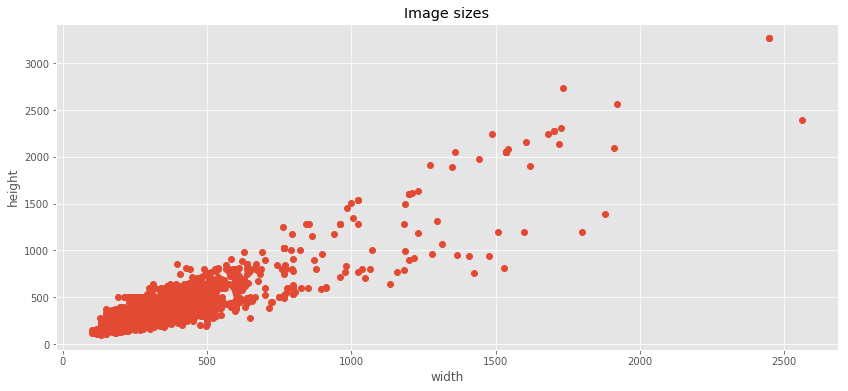

In [10]:
plt.plot(shapes[:, 0], shapes[:, 1], "o")
plt.title("Image sizes")
plt.xlabel("width")
_ = plt.ylabel("height")

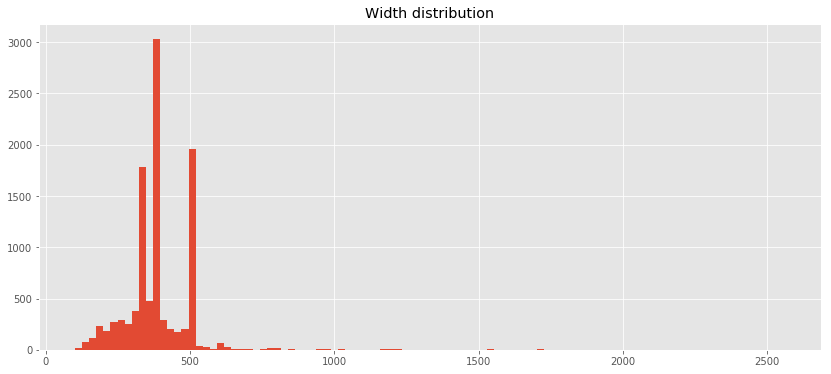

In [11]:
plt.hist(shapes[:, 0], bins=100)
_ = plt.title("Width distribution")

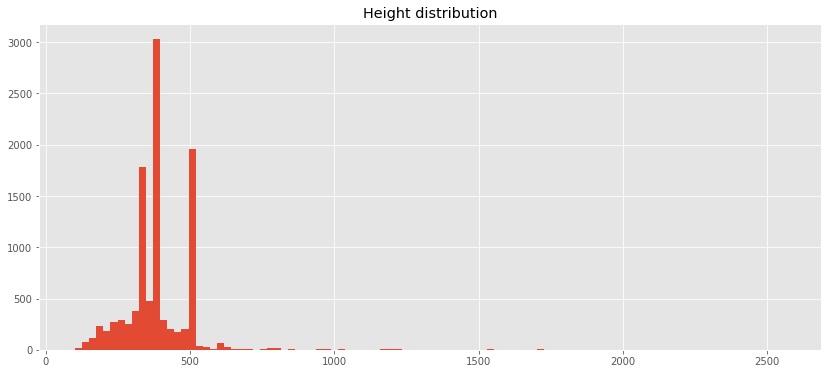

In [12]:
plt.hist(shapes[:, 0], bins=100)
_ = plt.title("Height distribution")

In [13]:
np.mean(shapes[:, 0]), min(shapes[:, 1])

(386.74721189591077, 97)

In [14]:
shapes[:, 0].reshape(1, -1).shape

(1, 10222)

In [15]:
def linearRegression(X, Y, learning_rate = 0.01, epochs = 1000):
    m = X.shape[-1]
    n = 1
    
    graph = tf.Graph()
    
    with graph.as_default():
        
        with tf.name_scope("placeholders"):
            x = tf.placeholder(dtype=tf.float32, shape=(n, None), name="x")
            y = tf.placeholder(dtype=tf.float32, shape=(n, None), name="y")
        
        with tf.name_scope("variables"):
            W = tf.Variable(np.random.randn(1, 1), dtype=tf.float32, name="W")
            b = tf.Variable(np.random.randn(1, 1), dtype=tf.float32, name="b")
    
        with tf.name_scope("linear"):        
            y_pred = W*x + b
        
        with tf.name_scope("cost"):
            cost = tf.reduce_mean(tf.square(y - y_pred))
            tf.summary.scalar('cost', cost)

        with tf.name_scope("optimizer"):
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
        
        with tf.Session(graph = graph) as sess:
            writer = tf.summary.FileWriter('../dog_breeds/linearRegSummary9', graph = graph)
            merged_summaries = tf.summary.merge_all()
            tf.global_variables_initializer().run()

            for epoch in range(0, epochs):
                _, summary, current_cost, cW, cb = sess.run([optimizer, merged_summaries, cost, W, b], feed_dict={x: X, y: Y})
                
                #if epoch%1000 == 0:
                #    print('%s - %s - %s'%(current_cost, cW, cb))
                
                writer.add_summary(summary, epoch)
                    
                    
            writer.flush()
            writer.close()
        
        return (float(cW), float(cb))

W, b = linearRegression(shapes[:, 0].reshape(1, -1), shapes[:, 1].reshape(1, -1))
W, b

(1.099077582359314, 3.115471601486206)

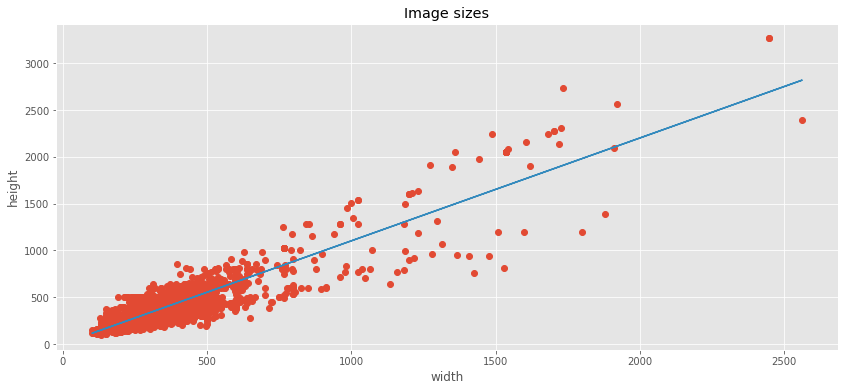

In [16]:
plt.plot(shapes[:, 0], shapes[:, 1], "o")
plt.title("Image sizes")
plt.xlabel("width")
_ = plt.ylabel("height")
plt.plot(shapes[:, 0], W*shapes[:, 0] + b)

In [17]:
numPx = 64
numPy = 64

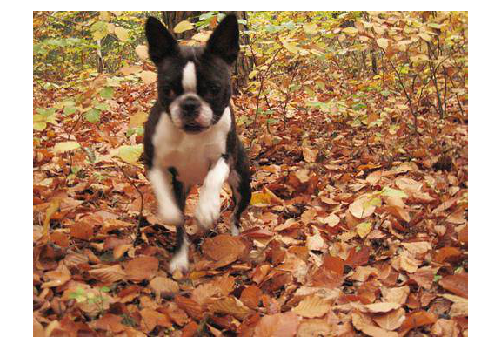

In [18]:
img = plt.imshow(spi.imread('../data/train/' + files[0]))
img.set_cmap('hot')
_ = plt.axis('off')

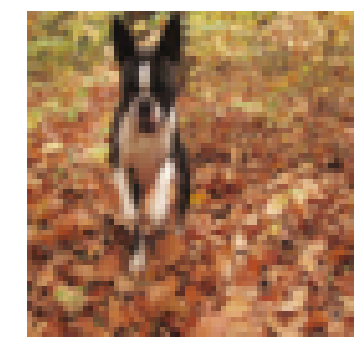

In [19]:
img = plt.imshow(sp.misc.imresize(spi.imread('../data/train/' + files[0]), (numPx, numPy)))
img.set_cmap('hot')
_ = plt.axis('off')

# Labels

In [20]:
train_Y_orig = pd.read_csv('../data/train/labels.csv', dtype = {'breed': np.str})
labels = train_Y_orig['breed'].unique()

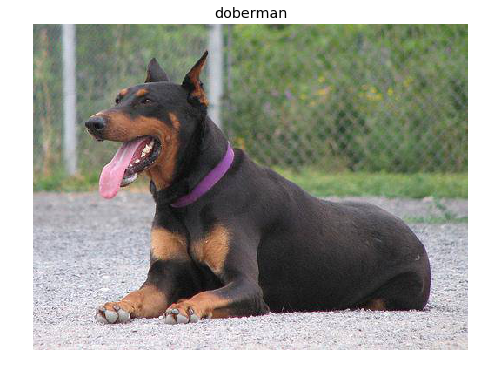

In [21]:
index = 20
label = train_Y_orig.iloc[index]
img = plt.imshow(spi.imread('../data/train/' + label.id + '.jpg'))
plt.title(label.breed)
img.set_cmap('hot')
_ = plt.axis('off')
#str(lb.inverse_transform(one_hot_labels[:, index].reshape(1, 120))[0])

In [22]:
lb = preprocessing.LabelBinarizer()
lb.fit(train_Y_orig['breed'])
lb.classes_
Y_train = np.asarray(lb.transform(train_Y_orig['breed']), dtype=np.float32).T
ids = train_Y_orig['id']

In [23]:
def load_batch(ids, Y_train, numPx, numPy, indexes = [], folder="../data/train"):
    batch_images = np.stack([sp.misc.imresize(spi.imread(folder + '/' + f + '.jpg'), (numPx, numPy)).reshape(-1) for f in ids[indexes]])
    batch_Y_train = Y_train[:, indexes]
    
    return ((batch_images/255.0).T, batch_Y_train)

In [24]:
def plot_batch(images, one_hot_labels, width, height, numPx, numPy):
    f, ax = plt.subplots(width, height)
    f.set_size_inches(12, 12)
    
    for i in range(0, width):
        for j in range(0, height):
            ax[i][j].axis('off')
            ax[i][j].set_title(str(lb.inverse_transform(one_hot_labels[:, i + j*height].reshape(1, 120))[0]))
            ax[i][j].imshow(images[:, i + j*height].reshape(numPx, numPy, -1))
            
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)

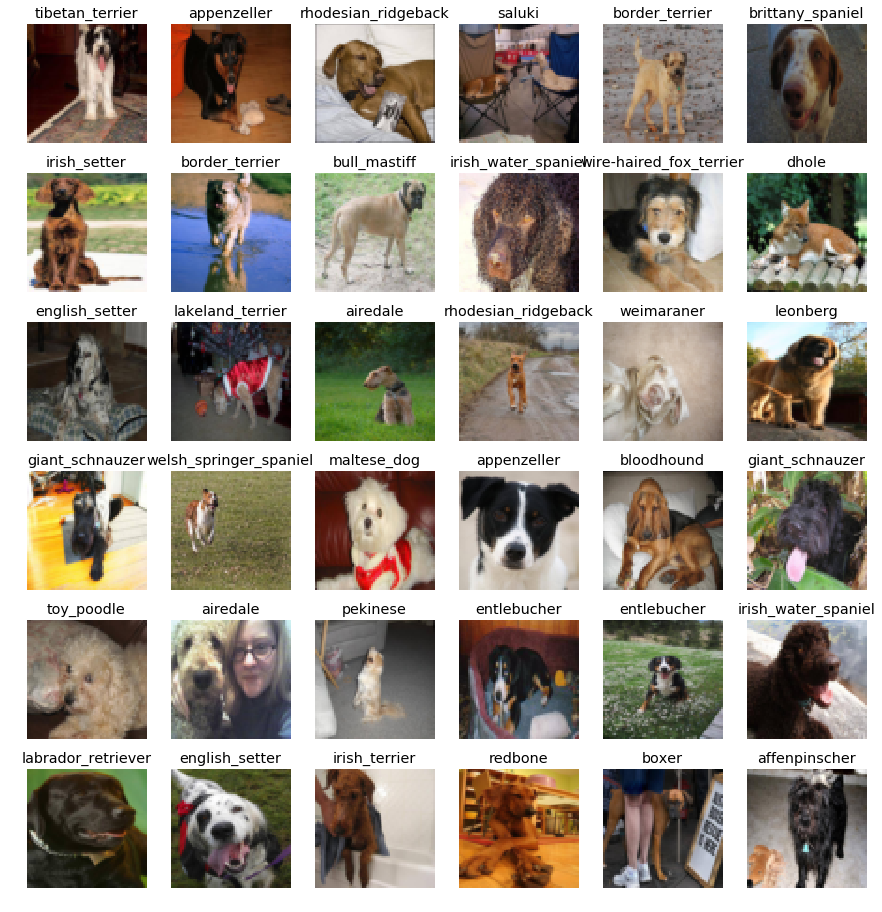

In [25]:
images, one_hot_labels = load_batch(ids, Y_train, numPx=64, numPy=64, indexes = np.random.permutation(np.arange(0, len(Y_train)))[:36])
plot_batch(images, one_hot_labels, 6, 6, 64, 64)